# Homework 2
### ASTR518
### Noah Franz

In [187]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord

import astroplan as planner
from astroplan.plots import plot_airmass 


# Problem 1

# Problem 2

In [12]:
# part (f)
def f_V(
    B:float,
    A_tele:u.Quantity,
    lambda_eff:u.Quantity=0.545*u.um, 
    f0:u.Quantity=363.1e-11*u.erg/(u.cm**2 * u.s * u.AA)
    ) -> u.Quantity:
    return f0*10**(-0.4*B) * A_tele * lambda_eff**2 / (c.h*c.c) *u.ct/u.arcsec**2

A_Bok = np.pi*(2.29*u.m/2)**2

f_bok = f_V(22, A_Bok).to(u.ct/u.s/u.arcsec**2)
f_bok

<Quantity 354.40787805 ct / (s arcsec2)>

In [161]:
n_pix_bok = 4 * (4096**2) * u.pix
T_bok = 0.8578

S_bok = T_bok * f_bok / n_pix_bok
S_bok, n_pix_bok

(<Quantity 4.53011807e-06 ct / (pix s arcsec2)>, <Quantity 67108864. pix>)

In [162]:
# part (g)
def obst(N_star, D, n_pix, g, S_gamma, R, FOV=1, SNR_goal=5):
    a = N_star**2
    b = -SNR_goal**2 * (N_star + D*n_pix/3600 + g*S_gamma*n_pix*FOV)
    c = -SNR_goal**2 * R * n_pix
        
    return np.roots((a,b,c)).max()

In [163]:

g_bok = 2
N_star_bok = T_bok*g_bok*f_V(15, A_Bok).to(u.ct/u.s/u.arcsec**2).value
D_bok = 3 # electrons / pixel / hour
n_pix_bok = (4096**2) #4*(4096**2)
R_bok = 12

obst(N_star_bok, D_bok, n_pix_bok, g_bok, S_bok.value, R_bok)

0.18496114675173925

In [167]:
A_kuiper = np.pi * (1.54*u.m)**2

T_kuiper = T_bok

g_kuiper = 3.1
N_star_kuiper = T_kuiper*g_kuiper*f_V(15, A_kuiper).to(u.ct/u.s/u.arcsec**2).value
D_kuiper = 16.6 # electrons / pixel / hour
n_pix_kuiper = 4096 * 4097
R_kuiper = 5
S_kuiper = T_kuiper * f_V(22, A_kuiper).to(u.ct/u.s/u.arcsec**2) / n_pix_kuiper
print(S_kuiper)

obst(N_star_kuiper, D_kuiper, n_pix_kuiper, g_kuiper, S_kuiper.value, R_kuiper)

3.277132231807387e-05 ct / (s arcsec2)


0.04259058792794036

# Problem 3

In [171]:
kpno = planner.Observer.at_site('kpno')
kpno

<Observer: name='kpno',
    location (lon, lat, el)=(-111.6 deg, 31.963333333333342 deg, 2119.999999997953 m),
    timezone=<UTC>>

In [176]:
altair = planner.FixedTarget.from_name('Altair')
vega = planner.FixedTarget.from_name('Vega')

coordinates = SkyCoord('20h41m25.9s', '+45d16m49.3s', frame='icrs')

deneb = planner.FixedTarget(name='Deneb', coord=coordinates)

In [177]:
from astropy.time import Time
time = Time('2015-06-16 12:00:00')

In [179]:
kpno.target_is_up(time, altair)

True

In [180]:
rise_time = kpno.target_rise_time(time, altair) + 5*u.minute
set_time = kpno.target_set_time(time, altair) - 5*u.minute

rise_time, set_time

(<Time object: scale='utc' format='jd' value=2457189.6417823476>,
 <Time object: scale='utc' format='jd' value=2457190.1645788914>)

In [182]:
sunset_tonight = kpno.sun_set_time(time, which='nearest')
sunrise_tonight = kpno.sun_rise_time(time, which='nearest')

sunset_tonight.iso, sunrise_tonight.iso

('2015-06-16 02:29:22.853', '2015-06-16 12:24:33.502')

In [185]:
start = np.max([sunset_tonight, rise_time])
stop = np.min([sunrise_tonight, set_time])

start.iso, stop.iso

('2015-06-16 03:24:09.995', '2015-06-16 12:24:33.502')

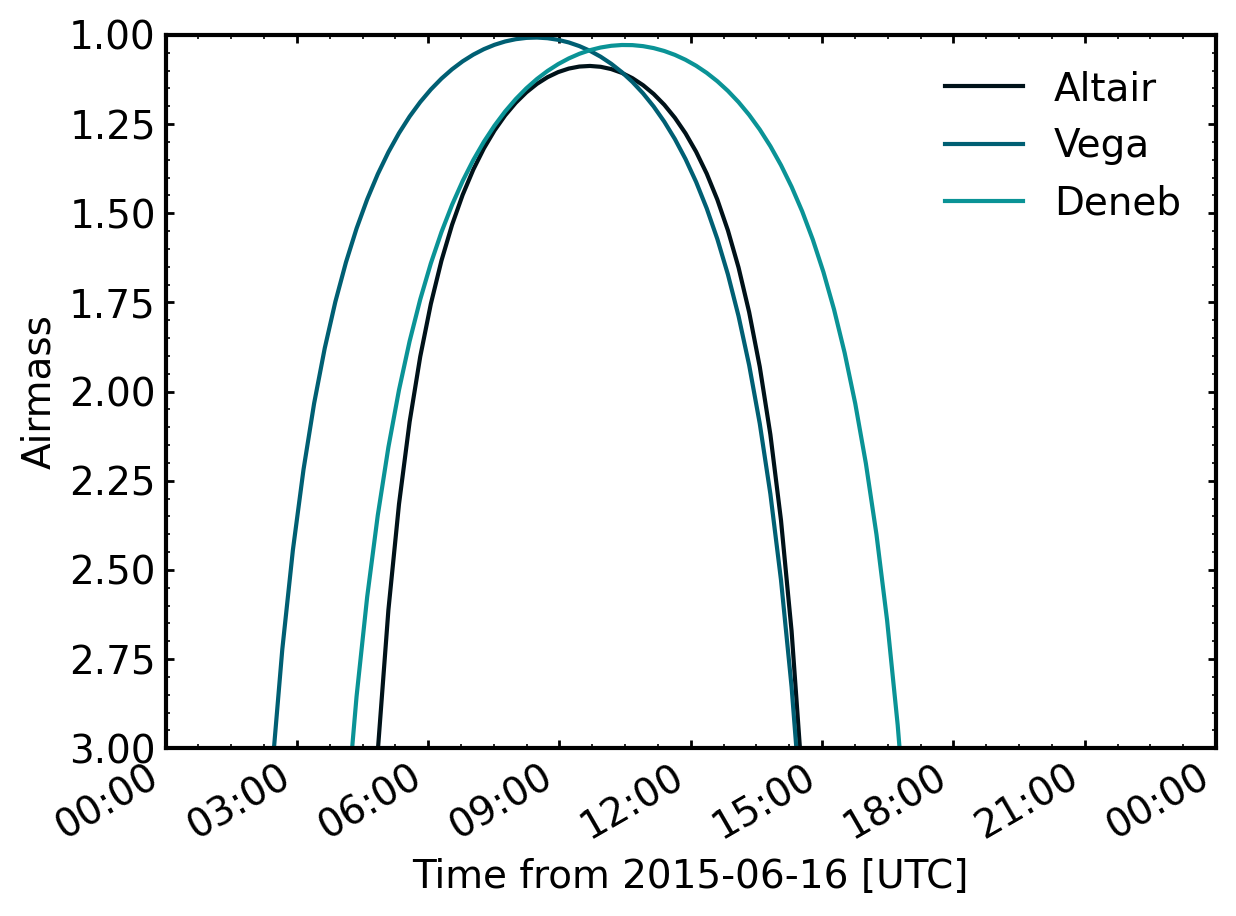

In [189]:
plot_airmass(altair, kpno, time) 
plot_airmass(vega, kpno, time) 
plot_airmass(deneb, kpno, time)  

plt.legend(loc=1, bbox_to_anchor=(1, 1)) 

plt.show() 

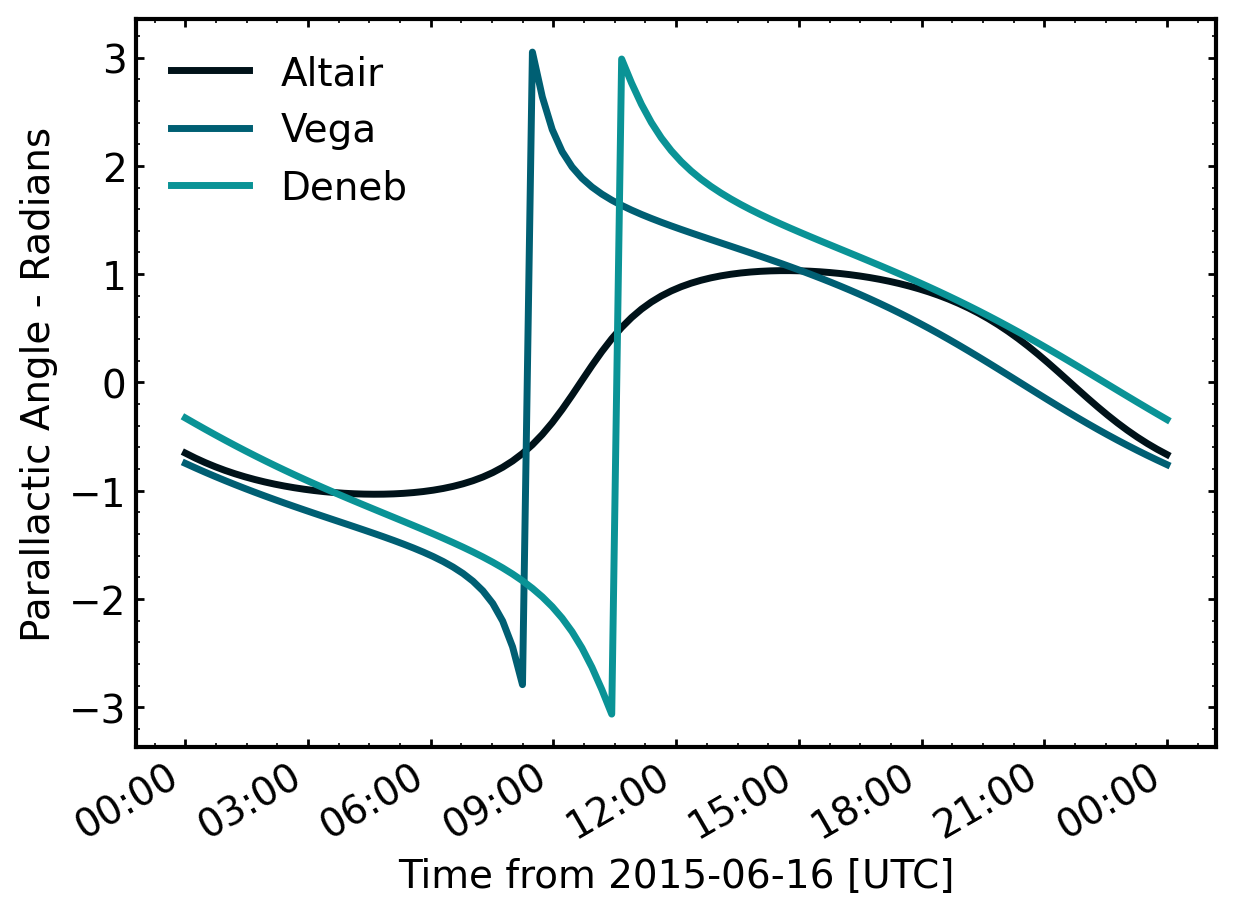

In [190]:
import matplotlib.pyplot as plt 

from astroplan.plots import plot_parallactic 

plot_parallactic(altair, kpno, time) 

plot_parallactic(vega, kpno, time) 

plot_parallactic(deneb, kpno, time) 

plt.legend(loc=2) 

plt.show() 
